# Project: Robot Force Prediction

## Objective
Build a model to predict force experienced by Robots in the System

## Context
A Robotic Manufacturing System is used to form metal sheets into desired geometries. The manufacturing cell uses two opposing robots R1 and R2, applying pressure onto a metal sheet to deform it. The robots move along a path that allows the system to give shape to the metal sheet.

R1, the "Forming Robot" pushes into the sheet, in direction Z, while moving along a certain path in the X/Y plane, parallel to the sheet metal surface. The opposing "Support Robot" R2 pushes into the sheet from the other side, providing the "pinch". It too moves along a similar path but obviously not exactly the same as R1, in the X/Y plane.

Both robots experience forces at the tool-tip in X, Y and Z directions, and these forces are captured by sensors embedded into the robots. The force data is recorded along with position data from Robot encoders, as well as orientation data in form of Euler angles (Pitch, Yaw, Roll) A, B, C for each robot.


## Problem Statement
Develop a model that would predict forces experienced by the tool-tips, for any path travelled by the robots.


# Clarification of the problem statement

Here, we need to predict the forces (in all three directions) for both the robots for the given path of the both robots. Here the input to the model: path of the robot (X, Y, Z coordinates and Euler angles); output: forces (six values). This problem can be considered as both and single-step and multi-step regression problem; (1) single-step: given the current position values, predict the force. (2) Given the last few position values (with the current), predict the force. Additionally, the force values for the last few positions (maintain a certaining lag/delay considering the latency of data collection and processing) can be used as features/input as well.

Initially, we will tackle the most naive problem setting, the single step case. In this case, we are assuming that force experienced by the robots is a function of their current position and angle. This assumption will be true if we are training and testing only for exactly similar sized and shaped geometries.

In our modeling approach, we can try out test scenario:
 
 1. Where we train and test on same dataset
 2. We train and test on two different dataset.
 
To make our model geometric shape and size agnostic, (1) the multi-step and (2) auto-regressive (using previous force values as input) approach might perform better, as (1) the robot might travel fast when the force to be exerted is small and vice versa, meaning the path traveled (movement speed) might affect the force, (2) force in close-by positions/time should be similar, intuitively.

# Exploratory Data Analysis

#### Objectives

* Visualize data
* statistical properties
* feature and output correlation
* feature selection

# import packages

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
import scipy
import numpy as np
import statsmodels.api as sm
from mpl_toolkits import mplot3d

# Read data

In [62]:
data_1 = pd.read_csv('Test1.csv')
data_2 = pd.read_csv('Test2.csv')
data_4 = pd.read_csv('Test4.csv')

# Dataset Properties

In [63]:
# data size and shape
print(f"data_1.shape: {data_1.shape}")
print(f"data_2.shape: {data_2.shape}")
print(f"data_4.shape: {data_4.shape}")

data_1.shape: (20091, 19)
data_2.shape: (20161, 19)
data_4.shape: (28987, 19)


# Probe Sample data

In [64]:
# Display data
data_1.head()

,t,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
0,1636579517,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2023,-179.8798,22.3221,783.1761,-772.5771,-2.326357,9.639795,-32.645949,11.805614,18.656085,-12.831012
1,1636579518,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-2.192611,9.531656,-33.073905,11.697159,18.462518,-12.250218
2,1636579519,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-2.103594,9.776526,-31.435784,11.662171,18.601191,-11.455588
3,1636579520,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-1.869649,9.100982,-31.719140,11.414681,18.489816,-12.538161
4,1636579521,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-2.336206,9.058406,-32.329481,11.223285,17.952984,-10.425429


In [65]:
data_2.head()

,t,a_enc_1,b_enc_1,c_enc_1,z_enc_1,y_enc_1,x_enc_1,a_enc_2,b_enc_2,c_enc_2,y_enc_2,z_enc_2,x_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
0,1637004936,-4.951100,0.0183,-0.0719,895.3528,324.101500,213.633700,-154.9772,0.2024,-179.8797,783.177100,-772.5771,22.319700,-4.168657,9.190370,3.382994,10.721234,19.250904,-16.732561
1,1637004937,-4.951100,0.0183,-0.0719,895.3528,324.101497,213.633700,-154.9772,0.2024,-179.8798,783.175400,-772.5771,22.320400,-4.242222,9.114000,2.850048,10.496114,18.593503,-15.032445
2,1637004938,-4.951100,0.0183,-0.0719,895.3528,324.101495,213.633699,-154.9772,0.2023,-179.8798,783.176098,-772.5771,22.322096,-4.392767,9.070117,3.059069,10.518067,18.748556,-16.711510
3,1637004939,-4.951199,0.0183,-0.0719,895.3528,324.099016,213.633303,-154.9772,0.2024,-179.8798,783.175400,-772.5771,22.320400,-4.088275,8.868698,3.615986,10.683620,18.412971,-16.228383
4,1637004940,-4.951200,0.0183,-0.0719,895.3528,324.099011,213.633302,-154.9772,0.2024,-179.8798,783.175400,-772.5771,22.320400,-4.399656,8.778390,3.318959,10.369269,18.326622,-16.881959


In [66]:
data_4.head()

,t,a_enc_1,b_enc_1,c_enc_1,z_enc_1,y_enc_1,x_enc_1,a_enc_2,b_enc_2,c_enc_2,y_enc_2,z_enc_2,x_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
0,1637362767,-4.9512,0.0183,-0.0719,895.3528,324.099000,213.633300,-154.9772,0.2024,-179.8798,783.175400,-772.5771,22.320400,-3.032278,10.828661,-50.630136,9.523903,18.360941,-4.349339
1,1637362768,-4.9511,0.0183,-0.0719,895.3528,324.101500,213.633700,-154.9772,0.2024,-179.8798,783.175400,-772.5771,22.320400,-2.943760,10.469587,-50.269871,9.388515,18.410955,-3.943046
2,1637362769,-4.9512,0.0183,-0.0719,895.3528,324.099008,213.633301,-154.9772,0.2024,-179.8798,783.175400,-772.5771,22.320400,-2.877008,10.641118,-51.787233,9.207934,17.434249,-1.858033
3,1637362770,-4.9510,0.0183,-0.0719,895.3528,324.103994,213.634199,-154.9772,0.2024,-179.8798,783.175400,-772.5771,22.320396,-3.104533,10.679307,-50.673054,9.114192,18.594151,-2.520182
4,1637362771,-4.9511,0.0183,-0.0719,895.3528,324.101492,213.633699,-154.9773,0.2024,-179.8798,783.174405,-772.5771,22.318711,-3.147975,10.443695,-50.880316,8.791884,18.243160,-4.777954


# Dataset properties: Feature and Output Columns

In [67]:
# columns
columns_1 = data_1.columns
print(f"data_1 columns: {columns_1}")

columns_2 = data_2.columns
print(f"data_2 columns: {columns_2}")

columns_4 = data_4.columns
print(f"data_4 columns: {columns_4}")

data_1 columns: Index(['t', 'a_enc_1', 'b_enc_1', 'c_enc_1', 'x_enc_1', 'y_enc_1', 'z_enc_1',
       'a_enc_2', 'b_enc_2', 'c_enc_2', 'x_enc_2', 'y_enc_2', 'z_enc_2',
       'fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'],
      dtype='object')
data_2 columns: Index(['t', 'a_enc_1', 'b_enc_1', 'c_enc_1', 'z_enc_1', 'y_enc_1', 'x_enc_1',
       'a_enc_2', 'b_enc_2', 'c_enc_2', 'y_enc_2', 'z_enc_2', 'x_enc_2',
       'fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'],
      dtype='object')
data_4 columns: Index(['t', 'a_enc_1', 'b_enc_1', 'c_enc_1', 'z_enc_1', 'y_enc_1', 'x_enc_1',
       'a_enc_2', 'b_enc_2', 'c_enc_2', 'y_enc_2', 'z_enc_2', 'x_enc_2',
       'fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'],
      dtype='object')


In [68]:
feature_columns = ['a_enc_1', 'b_enc_1', 'c_enc_1', 'x_enc_1', 'y_enc_1', \
                   'z_enc_1', 'a_enc_2', 'b_enc_2', 'c_enc_2', 'x_enc_2', 'y_enc_2', 'z_enc_2']
output_columns = ['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']

## Findings
All three dataset has same feature columns and output columns

**Features** 'a_enc_1', 'b_enc_1', 'c_enc_1', 'x_enc_1', 'y_enc_1', 'z_enc_1', 'a_enc_2', 'b_enc_2', 'c_enc_2', 'x_enc_2', 'y_enc_2', 'z_enc_2'

**Outputs** 'fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'

# Reorder data_2 and data_4 columns to be same as data_1 for easier comparisons (correlation plot/stats)

In [69]:
data_2 = data_2[columns_1]
data_4 = data_4[columns_1]

# Dataset Properties: Stats

In [70]:
data_1.describe()

,t,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
count,2.009100e+04,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000
mean,1.636590e+09,-89.243342,0.000876,0.001884,457.838727,196.582466,-65.004211,88.043654,0.001449,-48.584657,456.038225,199.566334,-76.051201,30.842497,90.713730,2518.588040,-29.178737,-103.178406,-740.617396
std,5.800524e+03,7.811876,0.002961,0.007390,197.669145,103.805836,100.980291,22.349876,0.029150,173.319815,202.637762,120.025141,81.255998,681.262919,1192.944410,582.206105,441.132354,729.100519,302.882751
min,1.636580e+09,-90.010338,-0.016044,-0.071996,89.375309,-1.773652,-176.784882,-178.388554,-2.199676,-180.000000,22.318914,-3.800164,-772.577100,-1919.499515,-1841.587267,-77.996067,-1488.688155,-1584.796551,-2315.788958
25%,1.636585e+09,-89.999386,-0.000656,0.000616,290.419367,100.769458,-109.418459,89.995441,-0.001200,-179.998927,288.144090,94.387694,-106.965317,-230.351587,-1176.059427,2447.281778,-256.660575,-773.561600,-811.944934
50%,1.636590e+09,-89.997882,0.000694,0.002700,456.793417,205.300159,-69.102747,89.997237,-0.000319,-179.997522,456.648642,205.461697,-65.262847,16.014140,93.456255,2654.714428,-34.196624,-173.398829,-662.764566
75%,1.636595e+09,-89.996412,0.002148,0.004283,623.566147,290.913058,-33.555666,89.998776,0.000556,179.998508,624.802175,294.557702,-28.547567,366.363106,1299.823169,2854.014779,159.026327,692.334489,-559.024622
max,1.636600e+09,-4.951004,0.023382,0.021594,830.689381,367.268497,895.352800,178.951853,1.164570,180.000000,831.872986,783.177337,-0.681790,1876.367359,2238.735152,3374.798895,1233.724258,1303.750689,-5.323892


In [71]:
data_2.describe()

,t,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
count,2.016100e+04,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000,20161.000000
mean,1.637015e+09,-89.840008,-0.000699,0.000721,460.665385,711.603851,-72.277629,89.747042,0.000593,-130.911287,460.362467,711.476284,-70.688186,41.760347,73.298569,2559.621166,-26.553260,-54.334268,-685.907699
std,5.820499e+03,3.332174,0.002414,0.005070,194.515037,105.521246,60.479199,9.187862,0.010802,123.538965,197.126196,108.975801,54.391704,672.682076,1168.250160,501.215279,402.136550,685.831686,274.119744
min,1.637005e+09,-90.010318,-0.015108,-0.071900,89.898378,324.099011,-176.890402,-177.937920,-0.369962,-180.000000,22.319700,513.252452,-772.577152,-1899.246669,-1763.564700,-37.069060,-1449.050761,-1536.288053,-2044.472668
25%,1.637010e+09,-90.000839,-0.001486,-0.000121,301.814720,612.954310,-109.446811,89.994217,-0.000800,-179.998514,300.041002,608.018472,-104.891509,-196.387494,-1192.311209,2502.060198,-233.739589,-687.830137,-754.341514
50%,1.637015e+09,-89.999789,-0.000711,0.000887,461.058382,720.530738,-70.620047,89.995203,0.000209,-179.997800,460.838464,721.179102,-65.174853,44.751381,133.872233,2675.870964,-46.200691,-207.880029,-620.034249
75%,1.637020e+09,-89.998807,0.000056,0.001900,619.004926,806.754679,-35.636347,89.996200,0.001200,-179.996037,620.169064,810.592095,-29.253553,385.348601,1270.926963,2846.983989,138.565205,705.416473,-514.173677
max,1.637025e+09,-4.951001,0.024100,0.027756,829.366949,884.270588,895.352800,179.282356,0.530392,180.000000,830.709862,885.958430,-0.476249,1831.276479,2079.791427,3346.377010,1143.240431,1359.332893,-8.365134


In [72]:
data_4.describe()

,t,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
count,2.898700e+04,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000,28987.000000
mean,1.637377e+09,-89.480526,-0.000712,0.000390,459.310574,1104.229093,-83.464438,88.634465,0.001090,-128.220887,458.345074,1106.168587,-88.693031,63.532739,178.475022,2415.879416,-35.277089,-61.451198,-628.716800
std,8.368219e+03,6.496682,0.002457,0.006459,232.638715,140.454673,94.392872,18.615997,0.018071,126.327457,236.393374,133.493524,77.549157,736.038983,1064.110562,531.193444,405.258023,658.310617,212.617184
min,1.637363e+09,-90.012872,-0.018559,-0.071900,20.101412,324.099000,-216.702079,-179.334265,-1.337127,-180.000000,18.570494,783.171690,-772.580026,-2022.676432,-1944.292631,-82.481350,-1585.198180,-1445.792510,-2305.813952
25%,1.637370e+09,-89.999979,-0.001564,-0.000218,263.145903,993.833906,-132.744547,89.994297,-0.001009,-179.998546,261.756266,988.772990,-129.534920,-188.674470,-796.656447,2322.899989,-219.718770,-681.734023,-770.930107
50%,1.637377e+09,-89.998892,-0.000795,0.000860,457.900875,1107.830538,-83.946756,89.995300,-0.000149,-179.997695,457.827811,1108.240463,-79.687021,55.832586,177.167422,2560.220980,-32.679150,-239.368792,-581.030656
75%,1.637385e+09,-89.997790,-0.000038,0.001945,654.481289,1226.647514,-41.258719,89.996271,0.000728,-179.995953,655.456116,1228.955424,-35.457538,418.211031,1212.101004,2749.530268,159.183308,612.734869,-484.119504
max,1.637392e+09,-4.950901,0.018300,0.026124,901.604391,1315.394509,895.352800,177.679265,0.348175,180.000000,903.055003,1317.020430,-0.206868,1921.166766,1890.530850,3342.554789,1130.962869,1276.602218,10.776189


## Findings

* The variables in the three datasets have similar distribution

# Dataset Properties: Variable Correlation

In [74]:
corr_1 = data_1.corr()
corr_2 = data_2.corr()
corr_4 = data_4.corr()

In [75]:
corr_1.style.background_gradient(cmap='coolwarm').set_precision(2)

,t,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
t,1.00,-0.17,0.12,0.22,0.02,-0.07,-0.59,0.15,-0.11,0.33,0.03,-0.12,-0.42,0.02,-0.02,0.37,-0.02,0.02,-0.26
a_enc_1,-0.17,1.00,0.51,-0.93,-0.11,0.11,0.89,-0.95,0.65,-0.07,-0.20,0.44,-0.80,-0.00,-0.01,-0.42,0.01,0.02,0.23
b_enc_1,0.12,0.51,1.00,-0.39,-0.08,0.06,0.37,-0.53,0.30,0.05,-0.12,0.23,-0.50,-0.03,0.07,-0.02,-0.04,0.01,0.12
c_enc_1,0.22,-0.93,-0.39,1.00,0.12,-0.09,-0.85,0.88,-0.61,0.16,0.20,-0.41,0.72,0.03,0.03,0.47,0.01,-0.02,-0.15
x_enc_1,0.02,-0.11,-0.08,0.12,1.00,-0.01,-0.10,0.11,-0.07,0.02,1.00,-0.05,0.09,-0.75,0.02,0.14,0.82,-0.02,-0.14
y_enc_1,-0.07,0.11,0.06,-0.09,-0.01,1.00,0.12,-0.11,0.07,-0.03,-0.02,0.94,-0.05,0.01,-0.85,-0.05,0.03,0.91,0.10
z_enc_1,-0.59,0.89,0.37,-0.85,-0.10,0.12,1.00,-0.84,0.58,-0.20,-0.18,0.41,-0.46,-0.01,0.01,-0.51,0.02,0.00,0.33
a_enc_2,0.15,-0.95,-0.53,0.88,0.11,-0.11,-0.84,1.00,-0.61,0.07,0.19,-0.43,0.76,0.00,0.01,0.38,-0.01,-0.01,-0.21
b_enc_2,-0.11,0.65,0.30,-0.61,-0.07,0.07,0.58,-0.61,1.00,-0.07,-0.13,0.29,-0.52,-0.01,-0.02,-0.28,0.01,0.02,0.15
c_enc_2,0.33,-0.07,0.05,0.16,0.02,-0.03,-0.20,0.07,-0.07,1.00,0.03,-0.05,-0.12,0.12,0.03,0.16,0.07,-0.02,-0.04


# Feature-Feature Correlation

In [76]:
feature_feature_corr_1 = data_1[feature_columns].corr()
feature_feature_corr_2 = data_2[feature_columns].corr()
feature_feature_corr_4 = data_4[feature_columns].corr()

In [77]:
feature_feature_corr_1.style.background_gradient(cmap='coolwarm').set_precision(2)

,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2
a_enc_1,1.00,0.51,-0.93,-0.11,0.11,0.89,-0.95,0.65,-0.07,-0.20,0.44,-0.80
b_enc_1,0.51,1.00,-0.39,-0.08,0.06,0.37,-0.53,0.30,0.05,-0.12,0.23,-0.50
c_enc_1,-0.93,-0.39,1.00,0.12,-0.09,-0.85,0.88,-0.61,0.16,0.20,-0.41,0.72
x_enc_1,-0.11,-0.08,0.12,1.00,-0.01,-0.10,0.11,-0.07,0.02,1.00,-0.05,0.09
y_enc_1,0.11,0.06,-0.09,-0.01,1.00,0.12,-0.11,0.07,-0.03,-0.02,0.94,-0.05
z_enc_1,0.89,0.37,-0.85,-0.10,0.12,1.00,-0.84,0.58,-0.20,-0.18,0.41,-0.46
a_enc_2,-0.95,-0.53,0.88,0.11,-0.11,-0.84,1.00,-0.61,0.07,0.19,-0.43,0.76
b_enc_2,0.65,0.30,-0.61,-0.07,0.07,0.58,-0.61,1.00,-0.07,-0.13,0.29,-0.52
c_enc_2,-0.07,0.05,0.16,0.02,-0.03,-0.20,0.07,-0.07,1.00,0.03,-0.05,-0.12
x_enc_2,-0.20,-0.12,0.20,1.00,-0.02,-0.18,0.19,-0.13,0.03,1.00,-0.09,0.16


In [78]:
feature_feature_corr_2.style.background_gradient(cmap='coolwarm').set_precision(2)

,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2
a_enc_1,1.00,0.21,-0.58,-0.05,-0.13,0.65,-0.75,0.79,-0.00,-0.08,0.04,-0.53
b_enc_1,0.21,1.00,-0.17,-0.01,-0.04,0.12,-0.25,0.07,0.02,-0.02,-0.01,-0.11
c_enc_1,-0.58,-0.17,1.00,0.06,0.07,-0.38,0.42,-0.44,0.27,0.08,-0.03,0.30
x_enc_1,-0.05,-0.01,0.06,1.00,0.01,-0.03,0.04,-0.04,0.03,1.00,-0.00,0.02
y_enc_1,-0.13,-0.04,0.07,0.01,1.00,-0.02,0.11,-0.10,-0.16,0.01,0.99,0.12
z_enc_1,0.65,0.12,-0.38,-0.03,-0.02,1.00,-0.46,0.52,-0.04,-0.05,0.09,0.28
a_enc_2,-0.75,-0.25,0.42,0.04,0.11,-0.46,1.00,-0.55,0.02,0.07,-0.02,0.37
b_enc_2,0.79,0.07,-0.44,-0.04,-0.10,0.52,-0.55,1.00,0.02,-0.07,0.03,-0.42
c_enc_2,-0.00,0.02,0.27,0.03,-0.16,-0.04,0.02,0.02,1.00,0.03,-0.16,-0.05
x_enc_2,-0.08,-0.02,0.08,1.00,0.01,-0.05,0.07,-0.07,0.03,1.00,-0.00,0.04


In [79]:
feature_feature_corr_4.style.background_gradient(cmap='coolwarm').set_precision(2)

,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2
a_enc_1,1.00,0.56,-0.86,-0.08,-0.42,0.80,-0.96,0.87,-0.03,-0.14,-0.18,-0.68
b_enc_1,0.56,1.00,-0.58,-0.04,-0.25,0.44,-0.58,0.44,-0.03,-0.08,-0.12,-0.38
c_enc_1,-0.86,-0.58,1.00,0.09,0.37,-0.69,0.83,-0.75,0.18,0.14,0.16,0.59
x_enc_1,-0.08,-0.04,0.09,1.00,0.03,-0.07,0.08,-0.07,0.02,1.00,0.01,0.05
y_enc_1,-0.42,-0.25,0.37,0.03,1.00,-0.24,0.41,-0.37,-0.00,0.06,0.97,0.39
z_enc_1,0.80,0.44,-0.69,-0.07,-0.24,1.00,-0.76,0.70,-0.06,-0.12,-0.04,-0.12
a_enc_2,-0.96,-0.58,0.83,0.08,0.41,-0.76,1.00,-0.82,0.03,0.14,0.18,0.65
b_enc_2,0.87,0.44,-0.75,-0.07,-0.37,0.70,-0.82,1.00,-0.01,-0.12,-0.16,-0.59
c_enc_2,-0.03,-0.03,0.18,0.02,-0.00,-0.06,0.03,-0.01,1.00,0.03,-0.01,-0.04
x_enc_2,-0.14,-0.08,0.14,1.00,0.06,-0.12,0.14,-0.12,0.03,1.00,0.02,0.09


# Average the three feature_feature correlation values to indentify global relationships

In [80]:
feature_feature_corr = sum([feature_feature_corr_1/3, feature_feature_corr_2/3, feature_feature_corr_4/3]) 
feature_feature_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2
a_enc_1,1.00,0.43,-0.79,-0.08,-0.15,0.78,-0.89,0.77,-0.03,-0.14,0.10,-0.67
b_enc_1,0.43,1.00,-0.38,-0.05,-0.08,0.31,-0.45,0.27,0.01,-0.07,0.03,-0.33
c_enc_1,-0.79,-0.38,1.00,0.09,0.11,-0.64,0.71,-0.60,0.20,0.14,-0.09,0.54
x_enc_1,-0.08,-0.05,0.09,1.00,0.01,-0.06,0.08,-0.06,0.03,1.00,-0.01,0.06
y_enc_1,-0.15,-0.08,0.11,0.01,1.00,-0.05,0.14,-0.13,-0.06,0.02,0.96,0.16
z_enc_1,0.78,0.31,-0.64,-0.06,-0.05,1.00,-0.69,0.60,-0.10,-0.11,0.15,-0.10
a_enc_2,-0.89,-0.45,0.71,0.08,0.14,-0.69,1.00,-0.66,0.04,0.13,-0.09,0.59
b_enc_2,0.77,0.27,-0.60,-0.06,-0.13,0.60,-0.66,1.00,-0.02,-0.11,0.06,-0.51
c_enc_2,-0.03,0.01,0.20,0.03,-0.06,-0.10,0.04,-0.02,1.00,0.03,-0.07,-0.07
x_enc_2,-0.14,-0.07,0.14,1.00,0.02,-0.11,0.13,-0.11,0.03,1.00,-0.02,0.10


# Findings:

* x_enc_1 and x_enc_2 always perfectly correlated (corr=1), which is intuitively understandable.
* however, y_enc_1 and y_enc_2 is not perfectly correlated (0.94, 0.99, 0.97). 
* We can remove either x_enc_1 or x_enc_2.

# output-output Correlation

In [82]:
output_output_corr_1 = data_1[output_columns].corr()
output_output_corr_2 = data_2[output_columns].corr()
output_output_corr_4 = data_4[output_columns].corr()

In [83]:
output_output_corr_1.style.background_gradient(cmap='coolwarm').set_precision(2)

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
fx_1,1.00,-0.03,-0.13,-0.84,0.03,0.14
fy_1,-0.03,1.00,0.09,-0.00,-0.96,-0.04
fz_1,-0.13,0.09,1.00,0.11,-0.07,0.07
fx_2,-0.84,-0.00,0.11,1.00,0.01,-0.13
fy_2,0.03,-0.96,-0.07,0.01,1.00,0.12
fz_2,0.14,-0.04,0.07,-0.13,0.12,1.00


In [84]:
output_output_corr_2.style.background_gradient(cmap='coolwarm').set_precision(2)

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
fx_1,1.00,-0.07,-0.15,-0.85,0.07,0.13
fy_1,-0.07,1.00,0.15,0.04,-0.96,0.08
fz_1,-0.15,0.15,1.00,0.13,-0.11,0.26
fx_2,-0.85,0.04,0.13,1.00,-0.05,-0.16
fy_2,0.07,-0.96,-0.11,-0.05,1.00,0.01
fz_2,0.13,0.08,0.26,-0.16,0.01,1.00


In [85]:
output_output_corr_4.style.background_gradient(cmap='coolwarm').set_precision(2)

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
fx_1,1.00,-0.07,-0.11,-0.87,0.05,0.04
fy_1,-0.07,1.00,0.24,0.04,-0.95,0.32
fz_1,-0.11,0.24,1.00,0.05,-0.18,0.26
fx_2,-0.87,0.04,0.05,1.00,-0.02,-0.04
fy_2,0.05,-0.95,-0.18,-0.02,1.00,-0.29
fz_2,0.04,0.32,0.26,-0.04,-0.29,1.00


In [86]:
# Average the three correlation dataframe

In [87]:
output_output_corr = sum([output_output_corr_1/3, output_output_corr_2/3, output_output_corr_4/3]) 
output_output_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
fx_1,1.00,-0.06,-0.13,-0.85,0.05,0.10
fy_1,-0.06,1.00,0.16,0.03,-0.96,0.12
fz_1,-0.13,0.16,1.00,0.10,-0.12,0.19
fx_2,-0.85,0.03,0.10,1.00,-0.02,-0.11
fy_2,0.05,-0.96,-0.12,-0.02,1.00,-0.05
fz_2,0.10,0.12,0.19,-0.11,-0.05,1.00


# feature and output correlation

In [91]:
filtered_corr_1 = corr_1.filter(items=feature_columns, axis=0)[output_columns]
filtered_corr_2 = corr_2.filter(items=feature_columns, axis=0)[output_columns]
filtered_corr_4 = corr_4.filter(items=feature_columns, axis=0)[output_columns]
filtered_corr = sum([filtered_corr_1/3, filtered_corr_2/3, filtered_corr_4/3]) 
filtered_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
a_enc_1,-0.00,-0.01,-0.35,0.01,0.01,0.19
b_enc_1,-0.03,0.07,-0.06,-0.02,-0.01,0.06
c_enc_1,0.07,0.01,0.28,-0.01,-0.01,-0.09
x_enc_1,-0.74,0.03,0.12,0.81,-0.02,-0.10
y_enc_1,0.02,-0.81,-0.03,0.01,0.86,-0.08
z_enc_1,-0.01,-0.01,-0.45,0.01,0.01,0.29
a_enc_2,0.00,0.01,0.29,-0.01,-0.01,-0.16
b_enc_2,-0.01,-0.01,-0.27,0.00,0.01,0.16
c_enc_2,0.07,0.09,0.10,0.02,-0.07,0.05
x_enc_2,-0.74,0.03,0.14,0.81,-0.02,-0.11


# Findings

* x_enc_1 (x_enc_2) and y_enc_1 (y_enc_2) are negatively correlated with fx_1 and fy_1; and positively correlated with fx_2 and fy_2. However, z_enc_1 and z_enc_2 does not have very strong relationship with any of the outputs, same for fz_1 and fz_2. 

# feature distribution

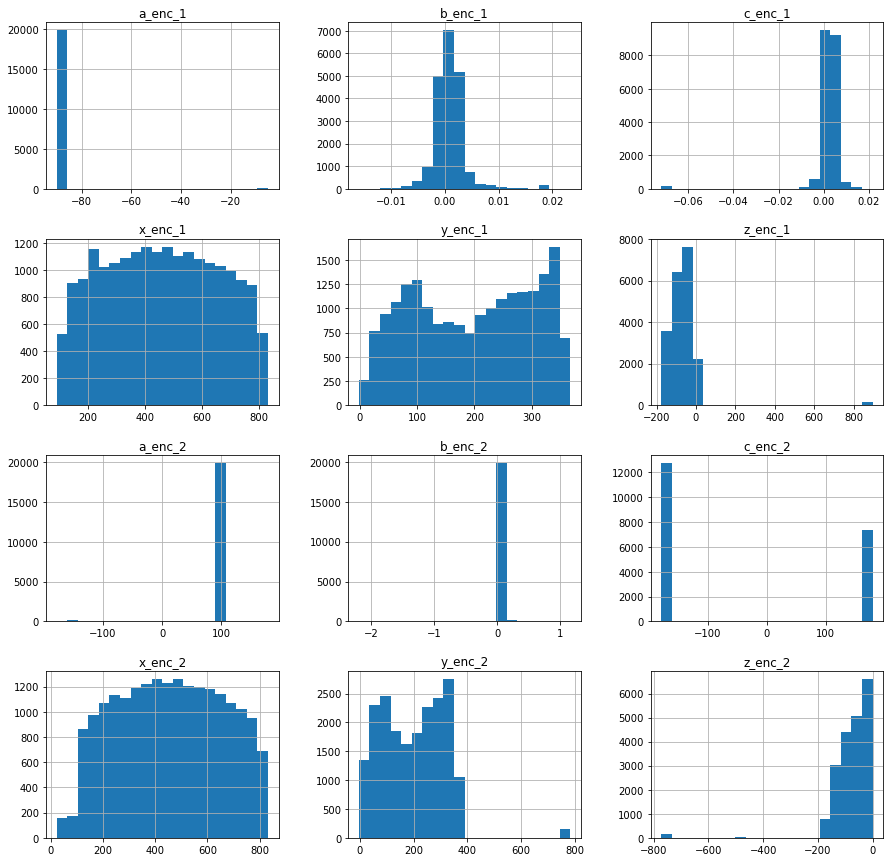

In [7]:
data_1[feature_columns].hist(bins=20,figsize=(15, 15))
plt.show()

# Findings

x_enc_1 (x_enc_2) and y_enc_1 (y_enc_2) somewhat noramlly distribute; rest skewed.


# 3D Visualization

In [101]:
X1 = data_1['x_enc_1']
Y1= data_1['y_enc_1']
Z1 = data_1['z_enc_1']
Fx1 = data_1['fx_1']
Fy1 = data_1['fy_1']
Fz1 = data_1['fz_1']

X2 = data_1['x_enc_2']
Y2= data_1['y_enc_2']
Z2 = data_1['z_enc_2']
Fx2 = data_1['fx_2']
Fy2 = data_1['fy_2']
Fz2 = data_1['fz_2']

# Data 1

In [106]:
def plot_3D(X, Y, Z, F, title):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plot = ax.scatter(X, Y, Z, c=F, cmap='viridis', linewidth=0.5)
    fig.colorbar(plot)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z');
    ax.set_title(title)

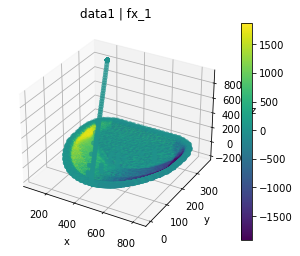

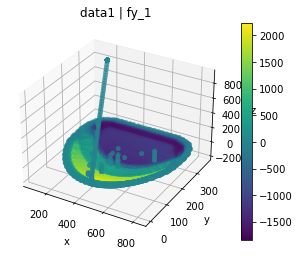

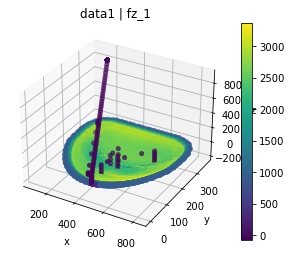

In [110]:
plot_3D(X1, Y1, Z1, Fx1, 'data1 | fx_1')
plot_3D(X1, Y1, Z1, Fy1, 'data1 | fy_1')
plot_3D(X1, Y1, Z1, Fz1, 'data1 | fz_1')

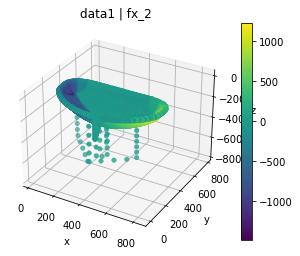

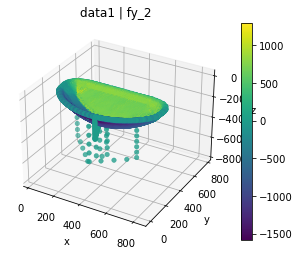

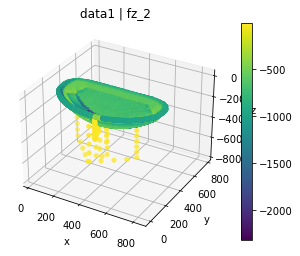

In [111]:
plot_3D(X2, Y2, Z2, Fx2, 'data1 | fx_2')
plot_3D(X2, Y2, Z2, Fy2, 'data1 | fy_2')
plot_3D(X2, Y2, Z2, Fz2, 'data1 | fz_2')

# Data 2

In [112]:
X1 = data_2['x_enc_1']
Y1= data_2['y_enc_1']
Z1 = data_2['z_enc_1']
Fx1 = data_2['fx_1']
Fy1 = data_2['fy_1']
Fz1 = data_2['fz_1']

X2 = data_2['x_enc_2']
Y2= data_2['y_enc_2']
Z2 = data_2['z_enc_2']
Fx2 = data_2['fx_2']
Fy2 = data_2['fy_2']
Fz2 = data_2['fz_2']

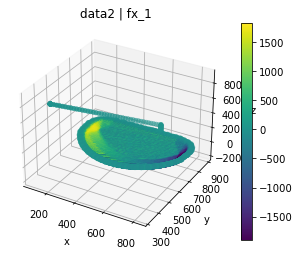

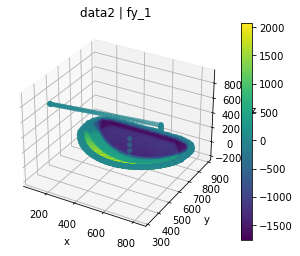

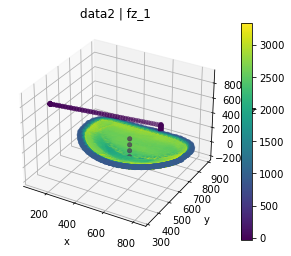

In [113]:
plot_3D(X1, Y1, Z1, Fx1, 'data2 | fx_1')
plot_3D(X1, Y1, Z1, Fy1, 'data2 | fy_1')
plot_3D(X1, Y1, Z1, Fz1, 'data2 | fz_1')

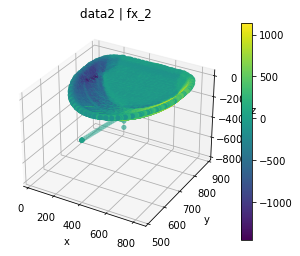

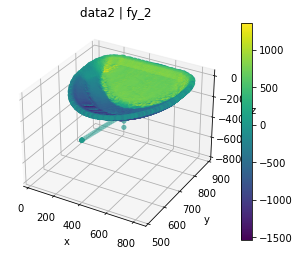

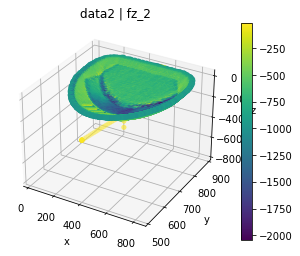

In [114]:
plot_3D(X2, Y2, Z2, Fx2, 'data2 | fx_2')
plot_3D(X2, Y2, Z2, Fy2, 'data2 | fy_2')
plot_3D(X2, Y2, Z2, Fz2, 'data2 | fz_2')

# Data 4

In [118]:
X1 = data_4['x_enc_1']
Y1= data_4['y_enc_1']
Z1 = data_4['z_enc_1']
Fx1 = data_4['fx_1']
Fy1 = data_4['fy_1']
Fz1 = data_4['fz_1']

X2 = data_4['x_enc_2']
Y2= data_4['y_enc_2']
Z2 = data_4['z_enc_2']
Fx2 = data_4['fx_2']
Fy2 = data_4['fy_2']
Fz2 = data_4['fz_2']

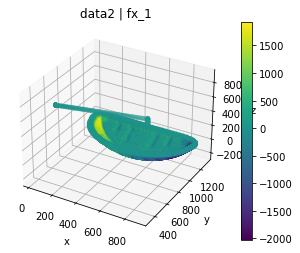

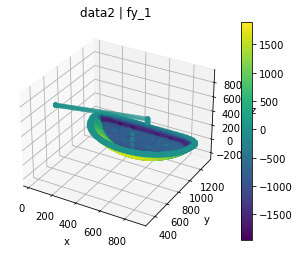

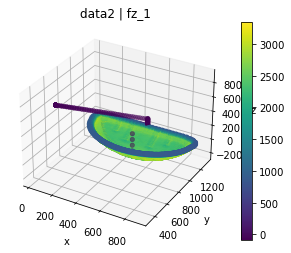

In [119]:
plot_3D(X1, Y1, Z1, Fx1, 'data2 | fx_1')
plot_3D(X1, Y1, Z1, Fy1, 'data2 | fy_1')
plot_3D(X1, Y1, Z1, Fz1, 'data2 | fz_1')

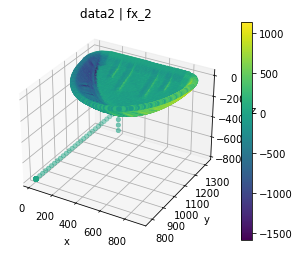

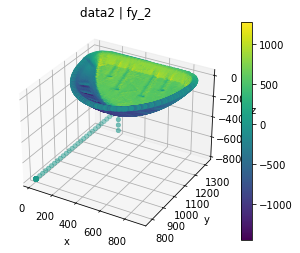

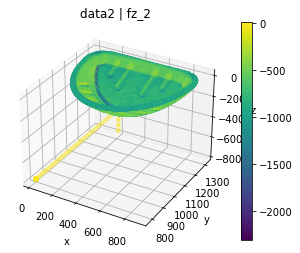

In [120]:
plot_3D(X2, Y2, Z2, Fx2, 'data2 | fx_2')
plot_3D(X2, Y2, Z2, Fy2, 'data2 | fy_2')
plot_3D(X2, Y2, Z2, Fz2, 'data2 | fz_2')

# Finding

Here, all three dataset seems to come from geometrically similar sahped and sized sheet metal formation task.
Hence, we can expect some level of predictive power across datasets.

# lagged correlation of force values

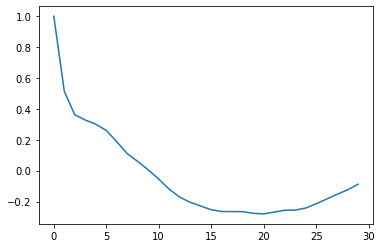

In [115]:
def auto_corr(data, lag):
    val = data.rolling(5).corr(data.shift(lag)).fillna(0)
    return val.mean()

lag_values = np.arange(0,30)
auto_corr_values = []

for lag_value in lag_values:
    auto_corr_values.append(auto_corr(data_1.fy_2, lag_value))
ax = plt.plot(auto_corr_values)

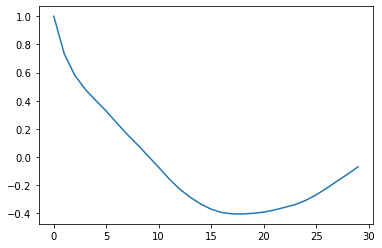

In [116]:
def auto_corr(data, lag):
    val = data.rolling(10).corr(data.shift(lag)).fillna(0)
    return val.mean()

lag_values = np.arange(0,30)
auto_corr_values = []

for lag_value in lag_values:
    auto_corr_values.append(auto_corr(data_1.fy_2, lag_value))
ax = plt.plot(auto_corr_values)

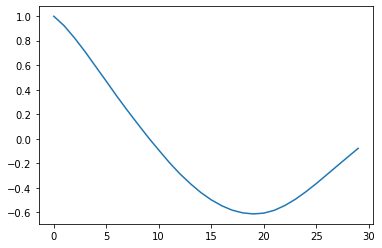

In [117]:
def auto_corr(data, lag):
    val = data.rolling(20).corr(data.shift(lag)).fillna(0)
    return val.mean()

lag_values = np.arange(0,30)
auto_corr_values = []

for lag_value in lag_values:
    auto_corr_values.append(auto_corr(data_1.fy_2, lag_value))
ax = plt.plot(auto_corr_values)

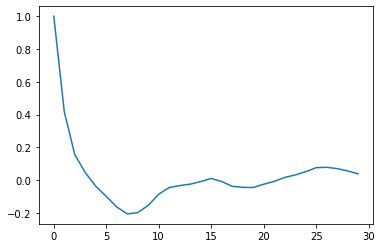

In [121]:
def auto_corr(data, lag):
    val = data.rolling(5).corr(data.shift(lag)).fillna(0)
    return val.mean()

lag_values = np.arange(0,30)
auto_corr_values = []

for lag_value in lag_values:
    auto_corr_values.append(auto_corr(data_1.fz_1, lag_value))
ax = plt.plot(auto_corr_values)

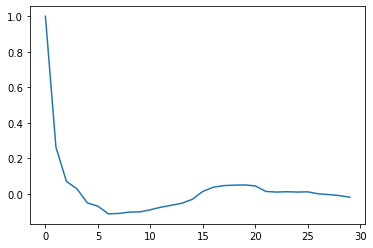

In [122]:
def auto_corr(data, lag):
    val = data.rolling(5).corr(data.shift(lag)).fillna(0)
    return val.mean()

lag_values = np.arange(0,30)
auto_corr_values = []

for lag_value in lag_values:
    auto_corr_values.append(auto_corr(data_1.fz_2, lag_value))
ax = plt.plot(auto_corr_values)

# Finding

No  auto-regressive property

# Check if change in position/angle has any predictive power

In [123]:
# take the difference of consecutive rows of feature values
def add_diff_features(data):
    diff_features = []
    for feature in feature_columns:
        diff_feature = feature + '_diff'
        diff_features.append(diff_feature)
        data[diff_feature] = data[feature] - data[feature].shift(1)
    data.fillna(0)
    return data, diff_features

def plot_correlation(data):
    data, diff_features = add_diff_features(data)
    data_filtered = data[diff_features + output_columns]
    
    corr = data_filtered.corr().filter(items=diff_features, axis=0)[output_columns]
    corr.style.background_gradient(cmap='coolwarm').set_precision(2)
    plt.show()

In [127]:
data_1, diff_features = add_diff_features(data_1)
data_filtered = data_1[diff_features + output_columns]
corr = data_filtered.corr().filter(items=diff_features, axis=0)[output_columns]
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
a_enc_1_diff,0.00,0.00,0.20,-0.00,-0.01,-0.11
b_enc_1_diff,0.00,-0.08,0.03,-0.00,0.10,-0.04
c_enc_1_diff,-0.07,-0.00,-0.02,0.10,-0.00,0.03
x_enc_1_diff,-0.35,-0.01,0.04,-0.06,0.00,0.05
y_enc_1_diff,-0.01,-0.17,-0.05,0.04,0.06,0.07
z_enc_1_diff,-0.00,-0.01,0.07,0.00,0.00,-0.03
a_enc_2_diff,-0.00,-0.00,-0.02,0.00,0.00,0.01
b_enc_2_diff,0.01,0.00,-0.00,-0.01,-0.01,0.00
c_enc_2_diff,-0.07,0.00,0.00,0.10,-0.00,-0.01
x_enc_2_diff,-0.35,-0.01,0.04,-0.06,0.00,0.05


In [128]:
data_2, diff_features = add_diff_features(data_2)
data_filtered = data_2[diff_features + output_columns]
corr = data_filtered.corr().filter(items=diff_features, axis=0)[output_columns]
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
a_enc_1_diff,0.00,0.00,0.23,-0.00,-0.00,-0.11
b_enc_1_diff,-0.01,-0.05,0.03,0.00,0.06,-0.04
c_enc_1_diff,0.10,-0.01,-0.07,-0.07,0.02,0.08
x_enc_1_diff,-0.34,-0.00,0.04,-0.05,0.01,0.05
y_enc_1_diff,-0.00,-0.16,-0.03,0.04,0.05,0.05
z_enc_1_diff,0.01,0.01,0.11,-0.01,-0.01,-0.05
a_enc_2_diff,-0.00,-0.00,-0.02,0.00,0.00,0.01
b_enc_2_diff,0.01,0.01,-0.00,-0.01,-0.01,0.01
c_enc_2_diff,-0.00,-0.01,-0.02,0.01,0.02,-0.01
x_enc_2_diff,-0.35,-0.00,0.05,-0.04,0.00,0.04


In [129]:
data_4, diff_features = add_diff_features(data_4)
data_filtered = data_4[diff_features + output_columns]
corr = data_filtered.corr().filter(items=diff_features, axis=0)[output_columns]
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
a_enc_1_diff,0.00,0.01,0.17,-0.00,-0.00,-0.11
b_enc_1_diff,0.01,-0.05,-0.01,-0.02,0.05,-0.03
c_enc_1_diff,0.02,0.01,-0.05,0.03,-0.00,0.14
x_enc_1_diff,-0.29,0.00,0.05,-0.07,0.01,0.06
y_enc_1_diff,0.00,-0.17,-0.01,0.04,0.04,-0.04
z_enc_1_diff,0.00,0.01,0.08,-0.00,-0.01,-0.04
a_enc_2_diff,-0.00,-0.00,-0.02,0.00,0.00,0.01
b_enc_2_diff,0.00,0.01,0.01,0.00,-0.00,0.00
c_enc_2_diff,-0.01,-0.00,-0.01,-0.00,-0.00,0.03
x_enc_2_diff,-0.30,0.00,0.05,-0.07,0.01,0.06


# Findings

z_enc_2 diff has some correlation with fz_2 in data2 and data4, but not strong.